<a href="https://colab.research.google.com/github/yeesem/Advanced-Tensorflow-Specialization/blob/main/OxfordPets_UNet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

# Download the Oxford-IIIT Pets Dataset

In [2]:
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.O4YUQI_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.O4YUQI_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Possible keys can access in the dataset dict
# contains test and train splits
print(dataset.keys())

dict_keys(['train', 'test'])


In [4]:
# See information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpw2y4q601tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

# Prepare the Dataset

In [22]:
# Preprocessing Utilities

# Data Augmentation
def random_flip(input_image,input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image,input_mask

# Data Normalization
def normalize(input_image,input_mask):
  input_image = tf.cast(input_image,tf.float32) / 255.0
  input_mask -= 1
  return input_image,input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128),method = 'nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128),method = 'nearest')
  input_image,input_mask = random_flip(input_image,input_mask)
  input_image,input_mask = normalize(input_image,input_mask)

  return input_image,input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128),method = 'nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128),method = 'nearest')
  input_image,input_mask = normalize(input_image,input_mask)

  return input_image,input_mask

In [16]:
# Preprocess the train and test sets
# num_parallel_calls: This parameter controls the level of parallelism. It determines how many
# elements of the dataset are processed concurrently.
# tf.data.experimental.AUTOTUNE is a special setting that allows TensorFlow to automatically decide the
# optimal number of parallel calls. It uses available CPU resources to dynamically determine the best
# parallelism level for performance, potentially speeding up data preprocessing.
train = dataset['train'].map(load_image_train,num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Shuffle and group the train set into batches
# train.cache(): caches the dataset in memory after the first iteration. This means that
# subsequent epochs will not need to re-read the data from disk, which can speed up training.
# The repeat() method repeats the dataset indefinitely. This is useful for training models where
# you want the training to continue for multiple epochs without manually restarting the dataset iteration.
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Do a prefetch to optimzie preprocessing
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

# Data and Metrics Visualization

In [18]:
# class list of the mask pixels
class_names = ['pet','background','outline']

def display_with_metrics(display_list,iou_list,dice_score_list):
  metrics_by_id = [(idx,iou,dice_score) for idx,(iou,dice_score) in enumerate(zip(iou_list,dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key = lambda tup : tup[1],reverse = True)

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx],iou,dice_score) for idx,iou,dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list,["Image","Predicted Mask","True Mask"],display_string = display_string)

def display(display_list,titles = [],display_string = None):
  plt.figure(figsize = (15,15))

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i + 1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string,fontsize = 12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()

def show_image_from_dataset(dataset):

  for image,mask in dataset.take(1):
    sample_image,sample_mask = image,mask
  display([sample_image,sample_mask],titles = ["Image",'True Mask'])

def plot_metrics(metric_name,title,ylim = 5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color = 'blue',label = metric_name)
  plt.plot(model_history.history['val_' + metric_name],color = 'green',label = 'val_' + metric_name)

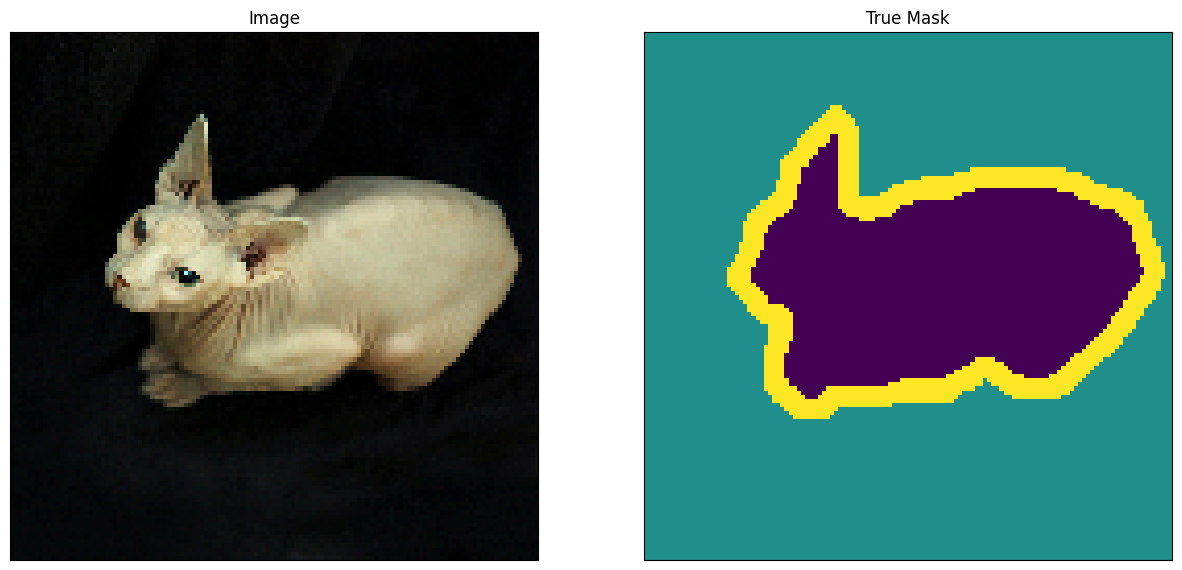

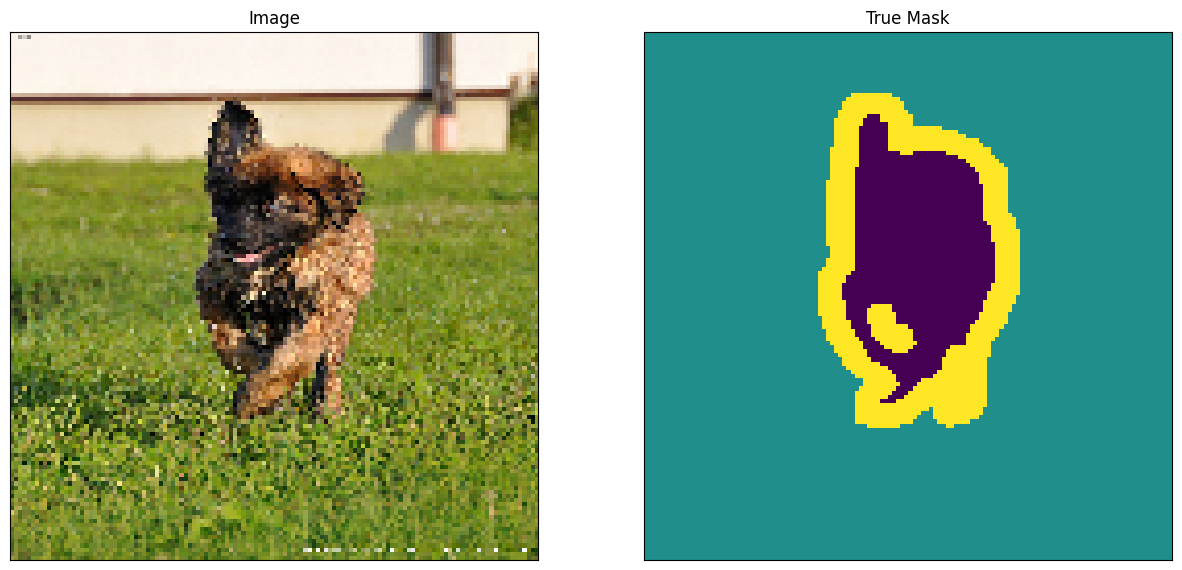

In [23]:
# Display an image from the train set
show_image_from_dataset(train)

# Display an image from the test set
show_image_from_dataset(test)

## Define the model

With the dataset prepared, you can now build the UNet. Here is the overall architecture as shown in class:

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

### Encoder

Like the FCN model you built in the previous lesson, the encoder here will have repeating blocks (red boxes in the figure below) so it's best to create functions for it to make the code modular. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. As discussed in class, each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [24]:
# Encoder Utilities
def conv2d_block(input_tensor,n_filters,kernel_size = 3):
  # First layer
  x = input_tensor

  for i in range(2):
    x = tf.keras.layers.Conv2D(
        filters = n_filters,
        kernel_size = (kernel_size,kernel_size),
        kernel_initializer = 'he_normal',
        padding = 'same'
    )(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x